In [1]:
import os
import pandas as pd
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt 
import numpy as np

In [7]:
def read_data():
    data_dir = "data/u.data"
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv((data_dir),  sep='\t',  names=names,)
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

In [8]:
data, num_users, num_items = read_data()
sparsity = 1 - len(data) / (num_users * num_items)
print(f'number of users: {num_users}, number of items: {num_items}')
print(f'matrix sparsity: {sparsity:f}')
print(data.head(5))


number of users: 943, number of items: 1682
matrix sparsity: 0.936953
   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596


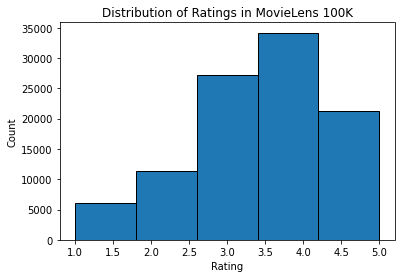

In [9]:
plt.hist(data['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

In [10]:
def split_data(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [11]:
def load_data(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [12]:
def split_and_load(split_mode='random', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data()
    
    train_data, test_data = split_data(
        data, num_users, num_items, split_mode, test_ratio)
    print(len(train_data))
    train_u, train_i, train_r, _ = load_data(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data(
        test_data, num_users, num_items, feedback)
    train_set = TensorDataset(
        torch.tensor(train_u), torch.tensor(train_i), torch.tensor(train_r))
    test_set = TensorDataset(
        torch.tensor(test_u), torch.tensor(test_i), torch.tensor(test_r))
    train_iter = DataLoader(
        train_set, shuffle=True, batch_size=batch_size)
    test_iter = DataLoader(
        test_set, batch_size=batch_size)
    return num_users, num_items, train_iter, test_iter

In [13]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self, num_factors, num_users, num_items, **kwargs):
        super(NeuralNetwork, self).__init__(**kwargs)
        self.P = torch.nn.Embedding(num_users, num_factors)
        self.Q = torch.nn.Embedding(num_items, num_factors)
        self.user_bias = torch.nn.Embedding(num_users, 1)
        self.item_bias = torch.nn.Embedding(num_items, 1)

    def forward(self, user_id, item_id):
        P_u = self.P(user_id)
        Q_i = self.Q(item_id)
        b_u = self.user_bias(user_id)
        b_i = self.item_bias(item_id)
        outputs = (P_u * Q_i).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i)
        return outputs.flatten()

Using cuda device


In [14]:
class RMSE(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def update(self,yhat,y):
        self.loss = torch.Tensor.sqrt(self.mse(yhat,y))
        #self.value = self.loss.item()
        return self.loss
    
    def get(self):
        return self.loss.item()

In [15]:
num_users, num_items, train_iter, test_iter = split_and_load(batch_size=512,
    test_ratio=0.1)
    
model = NeuralNetwork(30, num_users, num_items)

89817


In [16]:
loss_fn = RMSE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [17]:
def train(train_iter, model, loss_fn, optimizer):
    size = len(train_iter.dataset) 
    model.train()
    for batch, (u, i, r_ui) in enumerate(train_iter): #training one batch at a time  
        u.unsqueeze_(1)
        i.unsqueeze_(1)
        r_ui.unsqueeze_(1)
        r_hat = [model(u, i) for u, i in zip(u, i)] # matrix multiplication + biases
        
        output = [loss_fn.update(ypred, y.float()) for ypred, y in zip(r_hat, r_ui)]
        
        # Backpropagation
        for l in output:
            optimizer.zero_grad() # zero out gradient in each loop
            
            l.backward() # compute gradient in reverse direction
            optimizer.step() # conduct a single optimization step

            # monitor for decrease in Loss as training is in progress
            if batch % 500 == 0:
                output, current = l.item(), batch * len(r_hat)
                print(f"output: {output:>7f}  [{current:>5d}/{size:>5d}]")

In [18]:
def test(test_iter, model, loss_fn):
    # evaluate model with test data at the end of each epoch by monitoring changes in accuracy and loss
    size = len(test_iter.dataset) # 10k
    num_batches = len(test_iter) # 157 = len(test_test_iter)
    # sets the model in eval mode
    model.eval()
    # initialize monitoring value starting from zero
    correct = 0
    with torch.no_grad(): # no_drad to disable gradient calculation
        for batch, (u, i, r_ui) in enumerate(test_iter): #training one batch at a time  
            
            u.unsqueeze_(1)
            i.unsqueeze_(1)
            r_ui.unsqueeze_(1)
            
            r_hat = [model(u, i) for u, i in zip(u, i)] # matrix multiplication + biases
            #print(r_hat)
            test_loss_list = [loss_fn.update(r_hat, r_ui.float()) for r_hat, r_ui in zip(r_hat, r_ui)]
            test_loss = sum(test_loss_list)
                
            for r_hat, r_ui in zip(r_hat, r_ui): 
                r_hat.unsqueeze_(1)
                 
                correct += (int(r_hat) == r_ui).type(torch.float).sum().item() 
               
    test_loss /= num_batches # average loss
    correct /= size 
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [20]:
epochs = 5
# train model and evaluate
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # training
    train(train_iter, model, loss_fn, optimizer)
    # testing
    test(test_iter, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
output: 2.368594  [    0/89817]
output: 2.646844  [    0/89817]
output: 1.087451  [    0/89817]
output: 1.141411  [    0/89817]
output: 0.425769  [    0/89817]
output: 5.905680  [    0/89817]
output: 0.357352  [    0/89817]
output: 2.886741  [    0/89817]
output: 1.893301  [    0/89817]
output: 3.763188  [    0/89817]
output: 1.369793  [    0/89817]
output: 3.502516  [    0/89817]
output: 8.195311  [    0/89817]
output: 15.096620  [    0/89817]
output: 7.159943  [    0/89817]
output: 3.011268  [    0/89817]
output: 1.200037  [    0/89817]
output: 1.648712  [    0/89817]
output: 2.621368  [    0/89817]
output: 4.675879  [    0/89817]
output: 0.078270  [    0/89817]
output: 2.158494  [    0/89817]
output: 0.733123  [    0/89817]
output: 9.103440  [    0/89817]
output: 5.048301  [    0/89817]
output: 14.470308  [    0/89817]
output: 1.739451  [    0/89817]
output: 5.774135  [    0/89817]
output: 0.844546  [    0/89817]
output: 7.851248  [    0/89817